# **Final Project: Chest X-Ray Images Pneumonia**

Authors: Adrián Barreno Sánchez (adrian.barreno@alumnos.upm.es), Alberto González Delgado (alberto.gondelgado@alumnos.upm.es), Julian Elijah Politsch (julian.politsch@alumnos.upm.es), Angelo D'Angelo (angelo.dangelo@alumnos.upm.es)

Date: 01/2023

## 1. Introduction


## 2. Setup

### Starting Spark Session

In [ ]:
appname = "Chest X-Ray Images Pneumonia"

# Look into https://spark.apache.org/downloads.html for the latest version
spark_mirror = "https://mirrors.sonic.net/apache/spark"
spark_version = "3.3.1"
hadoop_version = "3"

# Install Java 8 (Spark does not work with newer Java versions)
! apt-get update > /dev/null
! apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Download and extract Spark binary distribution
! rm -rf spark-{spark_version}-bin-hadoop{hadoop_version}.tgz spark-{spark_version}-bin-hadoop{hadoop_version}
! wget -q {spark_mirror}/spark-{spark_version}/spark-{spark_version}-bin-hadoop{hadoop_version}.tgz
! tar xzf spark-{spark_version}-bin-hadoop{hadoop_version}.tgz

# The only 2 environment variables needed to set up Java and Spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/spark-{spark_version}-bin-hadoop{hadoop_version}"

# Set up the Spark environment based on the environment variable SPARK_HOME 
! pip install -q findspark
import findspark
findspark.init()

# Get the Spark session object (basic entry point for every operation)
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName(appname).master("local[*]").getOrCreate()

# Import GoogleDrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing data

In [ ]:
!unzip /content/drive/MyDrive/chest_x_ray.zip  > /dev/null


replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Importing packages


In [159]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from PIL import Image

## 3. Dataset


### Summary of the dataset

In [ ]:
for dirpath, dirnames, filenames in os.walk('/content/chest_xray'):
  print(f"There are {len(filenames)} images in {dirpath}")

There are 0 images in /content/chest_xray
There are 0 images in /content/chest_xray/val
There are 8 images in /content/chest_xray/val/PNEUMONIA
There are 8 images in /content/chest_xray/val/NORMAL
There are 0 images in /content/chest_xray/train
There are 3875 images in /content/chest_xray/train/PNEUMONIA
There are 1341 images in /content/chest_xray/train/NORMAL
There are 1 images in /content/chest_xray/__MACOSX
There are 3 images in /content/chest_xray/__MACOSX/chest_xray
There are 1 images in /content/chest_xray/__MACOSX/chest_xray/val
There are 9 images in /content/chest_xray/__MACOSX/chest_xray/val/PNEUMONIA
There are 9 images in /content/chest_xray/__MACOSX/chest_xray/val/NORMAL
There are 3 images in /content/chest_xray/__MACOSX/chest_xray/train
There are 3876 images in /content/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA
There are 1342 images in /content/chest_xray/__MACOSX/chest_xray/train/NORMAL
There are 3 images in /content/chest_xray/__MACOSX/chest_xray/test
There are 390 

### Getting all the pathes of the images


In [ ]:
train_images = glob.glob(f"/content/chest_xray/train/**/*.jpeg")
val_images = glob.glob(f"/content/chest_xray/val/**/*.jpeg")
test_images = glob.glob(f"/content/chest_xray/test/**/*.jpeg")


In [ ]:
print(f'Number of train samples:\t\t{len(train_images)}')
print(f'Number of validation samples :\t\t{len(val_images)}')
print(f'Number of test samples :\t\t{len(test_images)}')
print('=============================================')
print(f'Total number of samples :\t\t{len(train_images)+len(val_images)+len(test_images)}')

Number of train samples:		5216
Number of validation samples :		16
Number of test samples :		624
Total number of samples :		5856


### Creating dataframes of the data

0:NORMAL
1:PNEUMONIA

In [189]:
image_path=[]
label=[]
for path in train_images:
  if('NORMAL' in path):
    image_path.append(path)
    label.append(0)
  elif('PNEUMONIA' in path):
    image_path.append(path)
    label.append(1)
df_train=pd.DataFrame({'image': image_path,'label':label})
train_df=spark.createDataFrame(df_train)
train_df.toPandas().head(10)

,image,label
0,/content/chest_xray/train/PNEUMONIA/person110_...,1
1,/content/chest_xray/train/PNEUMONIA/person567_...,1
2,/content/chest_xray/train/PNEUMONIA/person1723...,1
3,/content/chest_xray/train/PNEUMONIA/person312_...,1
4,/content/chest_xray/train/PNEUMONIA/person256_...,1
5,/content/chest_xray/train/PNEUMONIA/person1156...,1
6,/content/chest_xray/train/PNEUMONIA/person1352...,1
7,/content/chest_xray/train/PNEUMONIA/person1180...,1
8,/content/chest_xray/train/PNEUMONIA/person1162...,1
9,/content/chest_xray/train/PNEUMONIA/person483_...,1


In [ ]:
train_df.describe().toPandas()

,summary,image,label
0,count,5216,5216
1,mean,None,0.7429064417177914
2,stddev,None,0.43707331766323415
3,min,/content/chest_xray/train/NORMAL/IM-0640-0001....,0
4,max,/content/chest_xray/train/NORMAL/IM-0640-0001....,1


In [ ]:
print("Distribution of labels in train data:")
train_df.groupBy().pivot('label').count().toPandas()

Distribution of labels in train data:


,0,1
0,1341,3875


In [198]:
image_path=[]
label=[]
for path in test_images:
  if('NORMAL' in path):
    image_path.append(path)
    label.append(0)
  elif('PNEUMONIA' in path):
    image_path.append(path)
    label.append(1)
df_test=pd.DataFrame({'image': image_path,'label':label})
test_df=spark.createDataFrame(df_test)
test_df.toPandas().head(10)

,image,label
0,/content/chest_xray/test/PNEUMONIA/person146_b...,1
1,/content/chest_xray/test/PNEUMONIA/person85_ba...,1
2,/content/chest_xray/test/PNEUMONIA/person10_vi...,1
3,/content/chest_xray/test/PNEUMONIA/person45_vi...,1
4,/content/chest_xray/test/PNEUMONIA/person113_b...,1
5,/content/chest_xray/test/PNEUMONIA/person161_b...,1
6,/content/chest_xray/test/PNEUMONIA/person134_b...,1
7,/content/chest_xray/test/PNEUMONIA/person125_b...,1
8,/content/chest_xray/test/PNEUMONIA/person69_vi...,1
9,/content/chest_xray/test/PNEUMONIA/person1628_...,1


In [ ]:
test_df.describe().toPandas()

,summary,image,label
0,count,624,624
1,mean,None,0.625
2,stddev,None,0.48451130415329574
3,min,/content/chest_xray/test/NORMAL/NORMAL2-IM-030...,0
4,max,/content/chest_xray/test/NORMAL/NORMAL2-IM-030...,1


In [ ]:
print("Distribution of labels in test data:")
test_df.groupBy().pivot('label').count().toPandas()

Distribution of labels in test data:


,0,1
0,234,390


In [199]:
image_path=[]
label=[]
for path in val_images:
  if('NORMAL' in path):
    image_path.append(path)
    label.append(0)
  elif('PNEUMONIA' in path):
    image_path.append(path)
    label.append(1)
df_val=pd.DataFrame({'image': image_path,'label':label})
df_val.head()
val_df=spark.createDataFrame(df_val)
val_df.toPandas().head(10)

,image,label
0,/content/chest_xray/val/PNEUMONIA/person1954_b...,1
1,/content/chest_xray/val/PNEUMONIA/person1950_b...,1
2,/content/chest_xray/val/PNEUMONIA/person1949_b...,1
3,/content/chest_xray/val/PNEUMONIA/person1951_b...,1
4,/content/chest_xray/val/PNEUMONIA/person1952_b...,1
5,/content/chest_xray/val/PNEUMONIA/person1946_b...,1
6,/content/chest_xray/val/PNEUMONIA/person1946_b...,1
7,/content/chest_xray/val/PNEUMONIA/person1947_b...,1
8,/content/chest_xray/val/NORMAL/NORMAL2-IM-1430...,0
9,/content/chest_xray/val/NORMAL/NORMAL2-IM-1442...,0


In [ ]:
val_df.describe().toPandas()

,summary,image,label
0,count,16,16
1,mean,None,0.5
2,stddev,None,0.5163977794943222
3,min,/content/chest_xray/val/NORMAL/NORMAL2-IM-1437...,0
4,max,/content/chest_xray/val/NORMAL/NORMAL2-IM-1437...,1


In [ ]:
print("Distribution of labels in val data:")
val_df.groupBy().pivot('label').count().toPandas()

Distribution of labels in val data:


,0,1
0,8,8


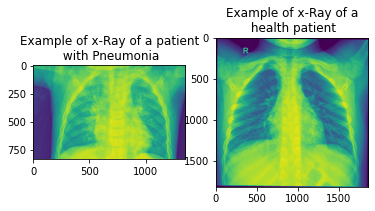

<Figure size 1600x800 with 0 Axes>

In [197]:
train_df.createOrReplaceTempView('table')
image_df_pn=spark.sql('SELECT image , label FROM table WHERE label = 1').first()
# print(image_df_pn)
image_path_pn=image_df_pn[0]
img_pn=Image.open(image_path_pn)

train_df.createOrReplaceTempView('table')
image_df_hlth=spark.sql('SELECT image , label FROM table WHERE label = 0').first()
# print(image_df_hlth)
image_path_hlth=image_df_hlth[0]
img_hlth=Image.open(image_path_hlth)


fig,ax=plt.subplots(1,2)
figure(figsize=(20, 10), dpi=80)
ax[0].set_title("Example of x-Ray of a patient\n with Pneumonia")
ax[0].imshow(img_pn)
ax[1].set_title("Example of x-Ray of a\n health patient")
ax[1].imshow(img_hlth)



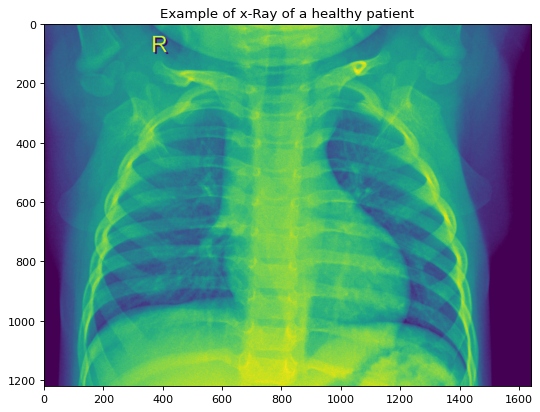

In [162]:
train_df.createOrReplaceTempView('table')
image_df=spark.sql('SELECT image FROM table WHERE label = 0').first()
image_path=image_df[0]
img=Image.open(image_path)
figure(figsize=(8, 6), dpi=80)
plt.title("Example of x-Ray of a healthy patient")
plt.imshow(img)

## 4. Preprocessing

## 5. Modeling

## 6. Training

## 7. Performance and evaluation

## 8. Discussions and conclusions
